In [4]:
#import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# **1. Exploratory Data Analysis**

In [5]:
df = pd.read_csv("diabetes.csv")

In [6]:
df.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
2,183,64,0,0,23.3,0.672,32,1
3,89,66,23,94,28.1,0.167,21,0
4,137,40,35,168,43.1,2.288,33,1


In [7]:
df.shape

(768, 8)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [9]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

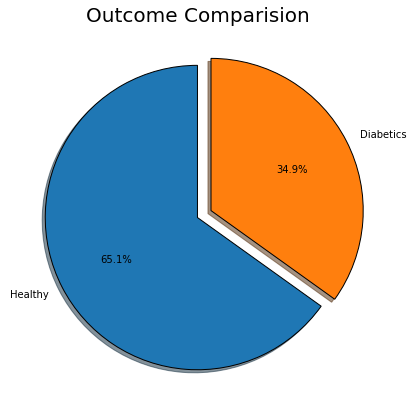

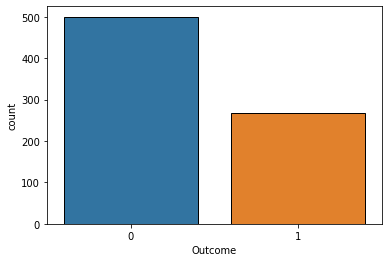

In [10]:
labels = ["Healthy","Diabetics"]
explode = [0, 0.1]
sizes = df.Outcome.value_counts().values

plt.figure(figsize= (7, 7))
plt.pie(sizes, explode= explode, labels= labels, autopct = "%1.1f%%",startangle=90, shadow=True, wedgeprops={'edgecolor':'black'})
plt.title("Outcome Comparision", fontsize = 20)
plt.show()
sns.countplot(data=df, x='Outcome', edgecolor='black')
plt.show()

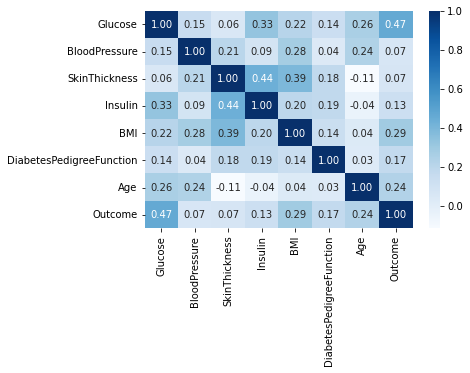

In [11]:
sns.heatmap(df.corr(), annot = True, cmap='Blues', fmt = ".2f")
plt.show()
#shows correlation between outcome and different features.
#The most correlation with depandant comes from Glucose:0.47

# **2. Data Preprocessing & Feature Engineering**

In [12]:
# drop the outcome column
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [13]:
X_scaled = StandardScaler().fit_transform(X)

In [14]:
X = pd.DataFrame(X_scaled, columns=X.columns)

# **3. Modeling & Prediction**

In [15]:
knn_model = KNeighborsClassifier().fit(X, y)

In [16]:
random_user = X.sample(1, random_state=45) # any one randomdy selected and seeded

knn_model.predict(random_user)

array([0])

# **4. Model Evaluation**

In [17]:
y_pred = knn_model.predict(X)

In [18]:
#P(class1/glucose)
#class 1 probability for each data set
y_prob = knn_model.predict_proba(X)[:, 1]
# array([[0.2, 0.8],
#        [1. , 0. ],
#        [0.2, 0.8],
#        ...,
#        [0.6, 0.4],
#        [0.2, 0.8],
#        [1. , 0. ]])
#for 1st data probability of class 1 is more so classified in 1 for second in class 0.

In [19]:
print(classification_report(y, y_pred))
# Macro is simply the arithmetic mean of the individual scores.
# weighted includes the individual sample sizes.

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       500
           1       0.76      0.68      0.72       268

    accuracy                           0.82       768
   macro avg       0.80      0.78      0.79       768
weighted avg       0.81      0.82      0.81       768



In [20]:
#roc_auc_score is defined as the area under the ROC curve, which is the curve having False Positive Rate on the x-axis 
#and True Positive Rate on the y-axis at all classification thresholds.
roc_auc_score(y, y_prob)
# It tells how much the model is capable of distinguishing between classes.
# If less than 0.5, it means that the model is performing worse than a random classifier, and hence, is of no use.
# The area under the ROC curve of the perfect test is 1.

0.8928992537313434

In [21]:
cv_results = cross_validate(knn_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [22]:
cv_results['test_accuracy'].mean()

0.7513878278584161

In [23]:
cv_results['test_f1'].mean()

0.625663167632784

In [24]:
cv_results['test_roc_auc'].mean()

0.7857767295597483

# **5. Hyperparameter Optimization**

In [25]:
knn_model = KNeighborsClassifier()

In [26]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [27]:
knn_params = {"n_neighbors": range(2, 50)}

In [28]:
knn_gs_best = GridSearchCV(knn_model,
                           knn_params,
                           cv=5,
                           n_jobs=-1,
                           verbose=1).fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [29]:
knn_gs_best.best_params_

{'n_neighbors': 23}

# **6. Final Model**

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X, y)

In [32]:
cv_results = cross_validate(knn_final,
                            X,
                            y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

In [33]:
cv_results['test_accuracy'].mean()

0.7813173754350224

In [34]:
cv_results['test_f1'].mean()

0.639496278575226

In [35]:
cv_results['test_roc_auc'].mean()

0.8236701607267646

In [36]:
random_user = X.sample(1)

In [37]:
knn_final.predict(random_user)

array([0])

In [38]:
def knn_model(X,y):
    X_train,X_test, y_train, y_test=train_test_split(X,y, test_size=0.3,random_state=42)
    knn_model=KNeighborsClassifier().fit(X_train,y_train)
    y_pred=knn_model.predict(X_test)
    print('Test Confusion Matrix:\n', confusion_matrix(y_test,y_pred))
    plot_confusion_matrix(knn_model,X_test,y_test)
    print("Accuracy Score  : ", accuracy_score(y_test,y_pred))
    print("Cross Val Score  : ",cross_val_score(knn_model,X_test,y_test,cv=10).mean())
    print("Classification Report:\n",classification_report(y_test,y_pred))
    #return y_pred

Test Confusion Matrix:
 [[121  30]
 [ 41  39]]
Accuracy Score  :  0.6926406926406926
Cross Val Score  :  0.6976449275362319
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77       151
           1       0.57      0.49      0.52        80

    accuracy                           0.69       231
   macro avg       0.66      0.64      0.65       231
weighted avg       0.68      0.69      0.69       231



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


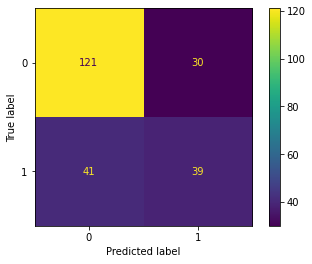

In [39]:
knn_model(X,y)